In [1]:
import xarray as xr
import datetime as dt
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import hvplot.xarray
from sea_breeze import utils
import pyproj
import pandas as pd
from dask.distributed import Client

def load_hima(datetime,x_slice=slice(-3e6,2e6),y_slice=slice(-1e6,-4.5e6)):

    #Load a single time slice of Himawari data
    ds = xr.open_mfdataset("/g/data/ra22/satellite-products/arc/obs/himawari-ahi/fldk/latest/"+\
                          datetime.strftime("%Y")+"/"+\
                          datetime.strftime("%m")+"/"+\
                          datetime.strftime("%d")+"/"+\
                          datetime.strftime("%H%M")+"/"+\
                          datetime.strftime("%Y%m%d%H%M%S")+\
                          "-P1S-ABOM_CREFL_B03-PRJ_GEOS141_500-HIMAWARI*-AHI.nc",chunks={"x":-1,"y":-1})

    #Define geostationary projection from file metadata projections firstly with cartopy then pyproj
    ccrs_proj = ccrs.Geostationary(central_longitude=ds["geostationary"].attrs["longitude_of_projection_origin"],satellite_height=35785863)
    pyproj_proj = pyproj.Proj(ccrs_proj)

    #Slice the dataset in x-y space. The defaults here roughly correspond to mainland Australia
    ds = ds.sel(x=x_slice,y=y_slice)
    
    return ds, pyproj_proj, ccrs_proj

def get_lat_lons(ds, proj):

    #Define x and y 2d coordinate arrays
    xx,yy=np.meshgrid(ds["x"],ds["y"])

    #Retrieve lats and lons from the projection
    lons, lats = proj(xx, yy, inverse=True)

    return lons, lats


In [2]:
client = Client()
client

2025-03-13 10:48:18,395 - distributed.preloading - INFO - Creating preload: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py
2025-03-13 10:48:18,401 - distributed.utils - INFO - Reload module schedplugin from .py file
2025-03-13 10:48:18,425 - distributed.preloading - INFO - Import preload module: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45203 instead
  warnings.warn(


Modifying workers


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /node/gadi-cpu-bdw-0037.gadi.nci.org.au/10961/proxy/45203/status,
Dashboard: /node/gadi-cpu-bdw-0037.gadi.nci.org.au/10961/proxy/45203/status,Workers: 7
Total threads: 7,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38255,Workers: 7
Dashboard: /node/gadi-cpu-bdw-0037.gadi.nci.org.au/10961/proxy/45203/status,Total threads: 7
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:38305,Total threads: 1
Dashboard: /node/gadi-cpu-bdw-0037.gadi.nci.org.au/10961/proxy/33675/status,Memory: 0 B
Nanny: tcp://127.0.0.1:42503,


In [3]:
#Load a single time step of himawari data, for a slice over mainland Australia
#ds,proj,ccrs_proj = load_hima(dt.datetime(2016,1,10,8))
ds,proj,ccrs_proj = load_hima(dt.datetime(2016,1,10,4))

#From the dataset, return lat lons using the himawari projection. Note that the lat lons aren't evenly spaced
lons, lats = get_lat_lons(ds, proj)

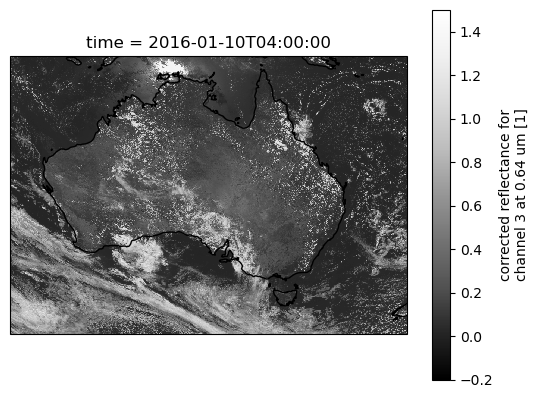

In [4]:
#Plot the time slice in the satellite projection

step = 15
ax = plt.axes(projection=ccrs_proj)
ds.isel(x=slice(0,-1,step),y=slice(0,-1,step)).channel_0003_corrected_reflectance.squeeze().plot(cmap="Greys_r",vmin=-0.2,vmax=1.5)
ax.coastlines()

In [5]:
#Define a smaller region of interest, and return the x-y bounds in the satellite projection

# min_lat = -38
# max_lat = -30
# min_lon = 112
# max_lon = 120
min_lat = -45
max_lat = -30
min_lon = 140
max_lon = 155

y_ind, x_ind = np.where((lons >= min_lon) & (lons <= max_lon) & (lats <= max_lat) & (lats >= min_lat))
print(ds["y"][y_ind].min().values, ds["y"][y_ind].max().values)
print(ds["x"][x_ind].min().values, ds["x"][x_ind].max().values)

-4245250.0 -3072750.0
-65750.0 1326750.0


In [11]:
#Now load a series of times, for the smaller region of interest defined above
ds_list = []
#for t in pd.date_range("2016-1-06 21:30","2016-1-07 11:00",freq="30min"):
for t in pd.date_range("2016-1-09 21:30","2016-1-10 11:00",freq="30min"):
    print(t)
    #temp_ds,proj,ccrs_proj = load_hima(t,x_slice = slice(-2541250., -1698750.),y_slice = slice(-3025750., -3713250.))
    temp_ds,proj,ccrs_proj = load_hima(t,x_slice = slice(-65750.0, 1326750.0),y_slice = slice(-3072750.0,-4245250.0))
    ds_list.append(temp_ds)

ds_multiple_times = xr.concat(ds_list,"time")

2016-01-09 21:30:00
2016-01-09 22:00:00
2016-01-09 22:30:00
2016-01-09 23:00:00
2016-01-09 23:30:00
2016-01-10 00:00:00
2016-01-10 00:30:00
2016-01-10 01:00:00
2016-01-10 01:30:00
2016-01-10 02:00:00
2016-01-10 02:30:00
2016-01-10 03:00:00
2016-01-10 03:30:00
2016-01-10 04:00:00
2016-01-10 04:30:00
2016-01-10 05:00:00
2016-01-10 05:30:00
2016-01-10 06:00:00
2016-01-10 06:30:00
2016-01-10 07:00:00
2016-01-10 07:30:00
2016-01-10 08:00:00
2016-01-10 08:30:00
2016-01-10 09:00:00
2016-01-10 09:30:00
2016-01-10 10:00:00
2016-01-10 10:30:00
2016-01-10 11:00:00


In [12]:
import xmovie

def plot_hima(ds,fig,tt,framedim,proj):

    ax = plt.axes(projection=proj)
    c = ds.isel({framedim:tt}).plot(cmap="Greys_r",vmin=-0.2,vmax=1.5,ax=ax,add_colorbar=False)
    ax.set_title(ds.isel(time=tt).time.values)
    fig.colorbar(c,extend="both")
    ax.coastlines()
    ax.gridlines(draw_labels=["bottom","left"],ls=":")
    plt.close(fig)
    
    
    return None, None 

In [13]:
mov = xmovie.Movie(
    ds_multiple_times.channel_0003_corrected_reflectance,
    pixelwidth=1200,
    pixelheight=1200,
    plotfunc=plot_hima,
    proj=ccrs_proj,
    input_check=False,
)


mov.save(
    "/scratch/gb02/ab4502/temp_figs/"+"test2"+".mp4",
    overwrite_existing=True,
    parallel=True,
    progress=True,
    framerate=5)  

Movie created at test2.mp4


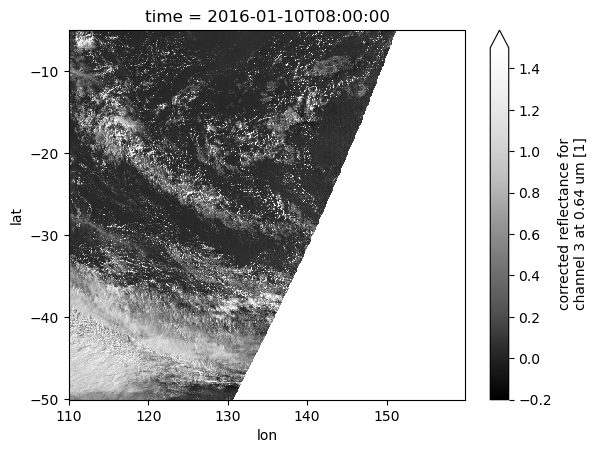

In [11]:
#From Sam's code

def load_hima_test(datetime):

    #Load a single time slice of Himawari data
    ds_test = xr.open_mfdataset("/g/data/ra22/satellite-products/arc/obs/himawari-ahi/fldk/latest/"+\
                          datetime.strftime("%Y")+"/"+\
                          datetime.strftime("%m")+"/"+\
                          datetime.strftime("%d")+"/"+\
                          datetime.strftime("%H%M")+"/"+\
                          datetime.strftime("%Y%m%d%H%M%S")+\
                          "-P1S-ABOM_CREFL_B03-PRJ_GEOS141_500-HIMAWARI*-AHI.nc",chunks={"x":-1,"y":-1})

    return ds_test

def lat_lon(ds_test):
    lat_min, lat_max = ds.attrs.get("geospatial_lat_min"), ds.attrs.get("geospatial_lat_max")  # Latitude bounds
    lon_min, lon_max = ds.attrs.get("geospatial_lon_min"), ds.attrs.get("geospatial_lon_max")  # Longitude bounds
    nx, ny = ds_test["x"].size, ds_test["y"].size

    # Generate lat/lon values
    ds_test["y"] = np.linspace(lat_min, lat_max, ny)
    ds_test["x"] = np.linspace(lon_min, lon_max, nx)

    ds_new = ds_test.rename({"x": "lon", "y": "lat"})

    return ds_new

#Plot the data
lat_lon(load_hima_test(dt.datetime(2016,1,10,8))).\
        sel(lat=slice(-50,-5),lon=slice(110,160)).\
        isel(lon=slice(0,-1,step),lat=slice(0,-1,step)).channel_0003_corrected_reflectance.squeeze().plot(cmap="Greys_r",vmin=-0.2,vmax=1.5)


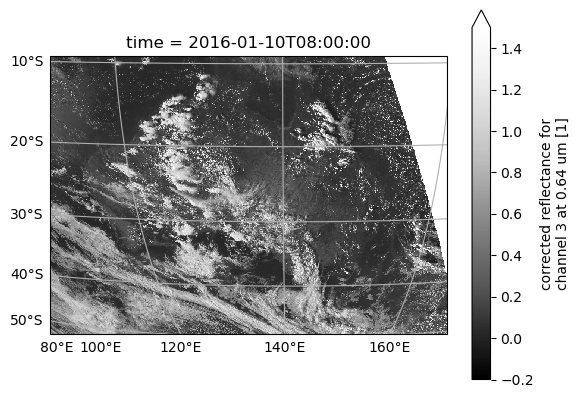

In [9]:
#And compare with the dataset in the original projection
ax=plt.axes(projection=ccrs_proj)
ds.isel(x=slice(0,-1,step),y=slice(0,-1,step)).channel_0003_corrected_reflectance.plot(cmap="Greys_r",vmin=-0.2,vmax=1.5)
ax.gridlines(draw_labels=["left","bottom"])